In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# data information
df = pd.read_csv("/content/AB_NYC_2019.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
df.shape

(47851, 12)

In [ ]:
df.isnull().sum()

,0
host_id,0
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0
minimum_nights,0
number_of_reviews,0
reviews_per_month,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47851 entries, 0 to 48894
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_id                         47851 non-null  int64  
 1   neighbourhood_group             47851 non-null  object 
 2   neighbourhood                   47851 non-null  object 
 3   latitude                        47851 non-null  float64
 4   longitude                       47851 non-null  float64
 5   room_type                       47851 non-null  object 
 6   price                           47851 non-null  int64  
 7   minimum_nights                  47851 non-null  int64  
 8   number_of_reviews               47851 non-null  int64  
 9   reviews_per_month               47851 non-null  float64
 10  calculated_host_listings_count  47851 non-null  int64  
 11  availability_365                47851 non-null  int64  
dtypes: float64(3), int64(6), object(3)
me

###Data Cleaning & Preprocessing

In [ ]:
# Droping irrelevant columns
df = df.drop(['id', 'name', 'host_name', 'last_review'], axis=1)

# Checking missing values
df.isnull().sum()

# Filling missing values
df['reviews_per_month'].fillna(0, inplace=True)
df.dropna(inplace=True)  # droping rows with null host_id, neighbourhood_group etc.

# Removing outliers in price
df = df[df['price'] <= 500]  # Cap at $500 for this analysis

###Exploratory Data Analysis (EDA)

Text(0.5, 1.0, 'Price Distribution')

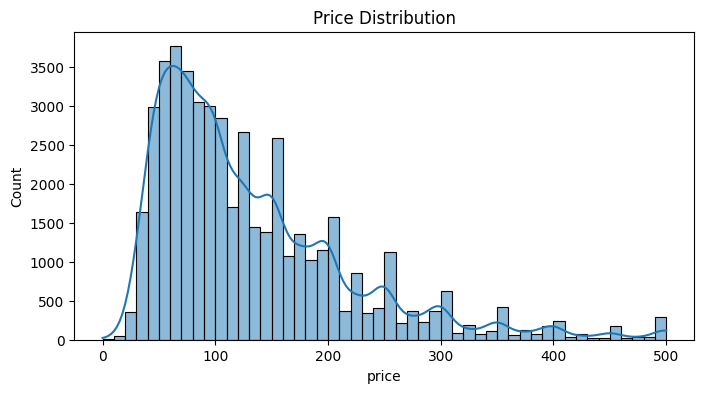

In [ ]:
# Price distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Price Distribution')

Text(0.5, 1.0, 'Price by Room Type')

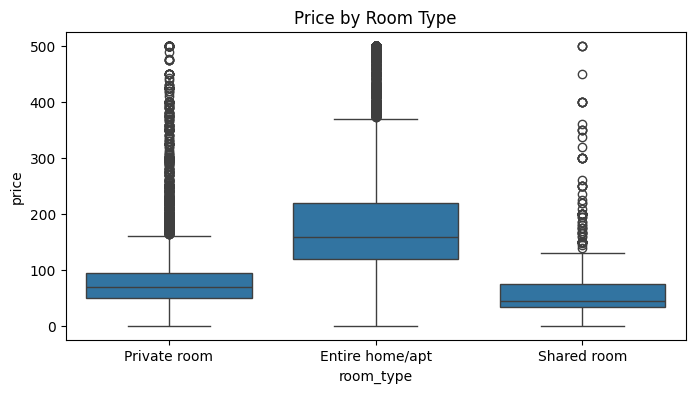

In [ ]:
# Price by room type
plt.figure(figsize=(8, 4))
sns.boxplot(x='room_type', y='price', data=df)
plt.title('Price by Room Type')

Text(0.5, 1.0, 'Price by Neighbourhood Group')

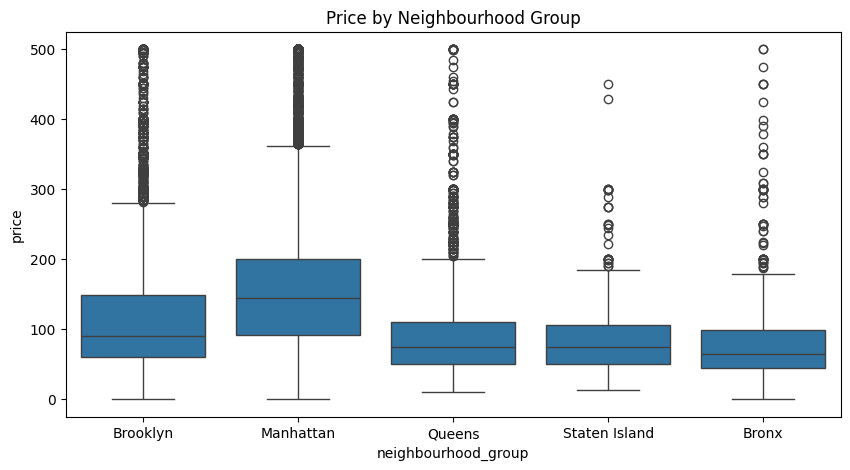

In [ ]:
# Price by Neighbourhood Group
plt.figure(figsize=(10, 5))
sns.boxplot(x='neighbourhood_group', y='price', data=df)
plt.title('Price by Neighbourhood Group')

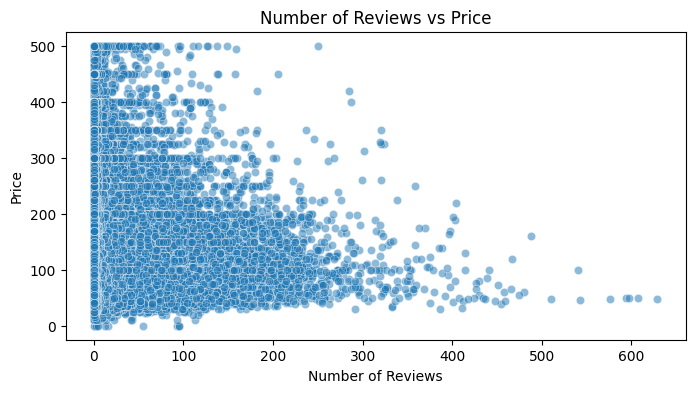

In [ ]:
# Review count vs Price
plt.figure(figsize=(8, 4))
sns.scatterplot(x='number_of_reviews', y='price', data=df, alpha=0.5)
plt.title('Number of Reviews vs Price')
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.show()

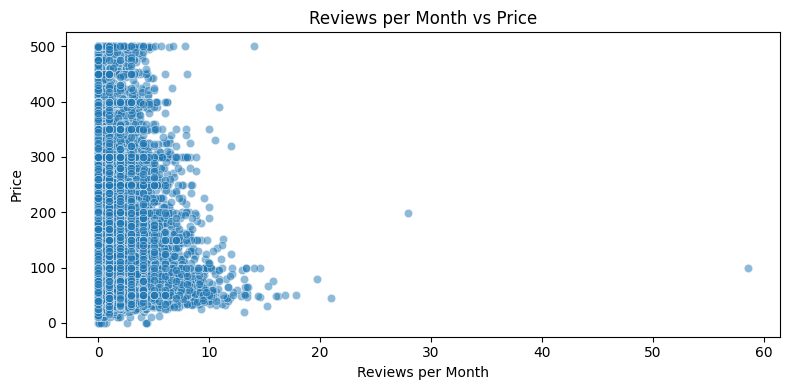

In [ ]:
# Reviews per month vs Price
plt.figure(figsize=(8, 4))
sns.scatterplot(x='reviews_per_month', y='price', data=df, alpha=0.5)
plt.title('Reviews per Month vs Price')
plt.xlabel('Reviews per Month')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

🔍Interpretation: Listings with more reviews or higher monthly review rates tend to command higher prices — indicating trust and willingness of guests to pay more.

####Increase Availability During Peak Travel Seasons

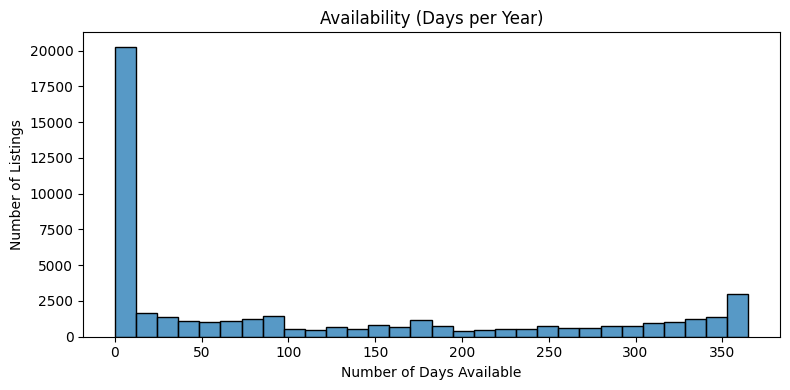

In [ ]:
# Availability histogram
plt.figure(figsize=(8, 4))
sns.histplot(df['availability_365'], bins=30, kde=False)
plt.title('Availability (Days per Year)')
plt.xlabel('Number of Days Available')
plt.ylabel('Number of Listings')
plt.tight_layout()
plt.show()

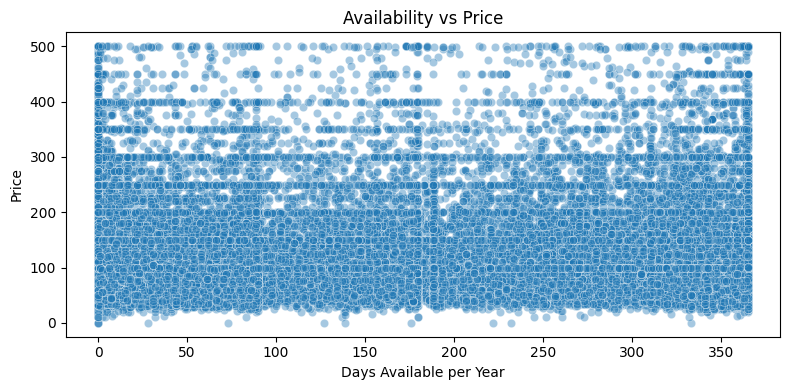

In [ ]:
# Price vs Availability
plt.figure(figsize=(8, 4))
sns.scatterplot(x='availability_365', y='price', data=df, alpha=0.4)
plt.title('Availability vs Price')
plt.xlabel('Days Available per Year')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

🔍Interpretation: Listings that are available year-round tend to maintain consistent bookings and potentially higher yearly revenue.

####Price variation within neighbourhood group and room type

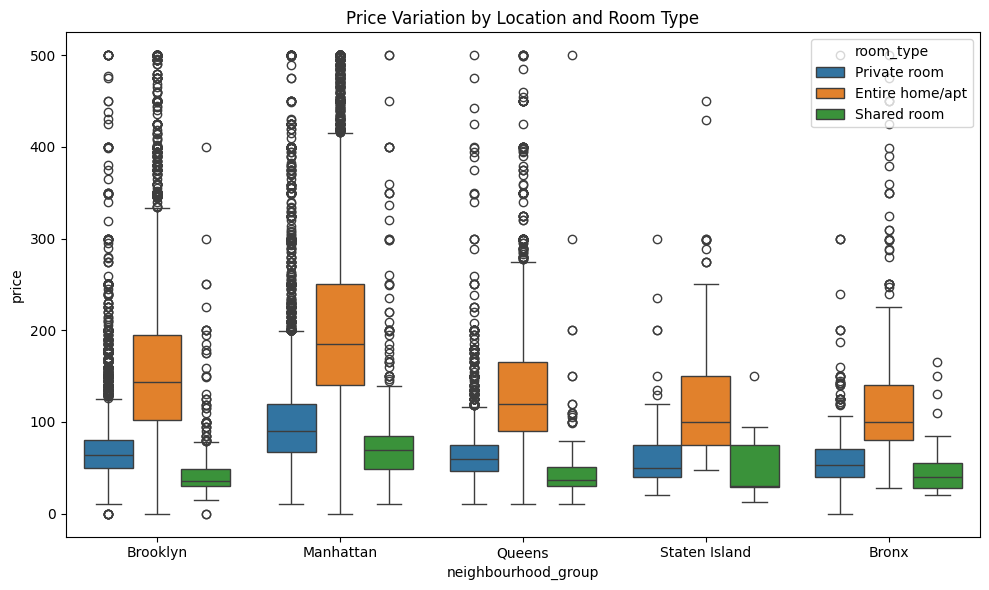

In [ ]:
# Price variation within neighbourhood group and room type
plt.figure(figsize=(10, 6))
sns.boxplot(x='neighbourhood_group', y='price', hue='room_type', data=df)
plt.title('Price Variation by Location and Room Type')
plt.tight_layout()
plt.show()

🔍 Interpretation: This plot shows large price ranges within the same neighborhood-room type, hinting at custom or dynamic pricing decisions by hosts.

####Minimum nights vs price

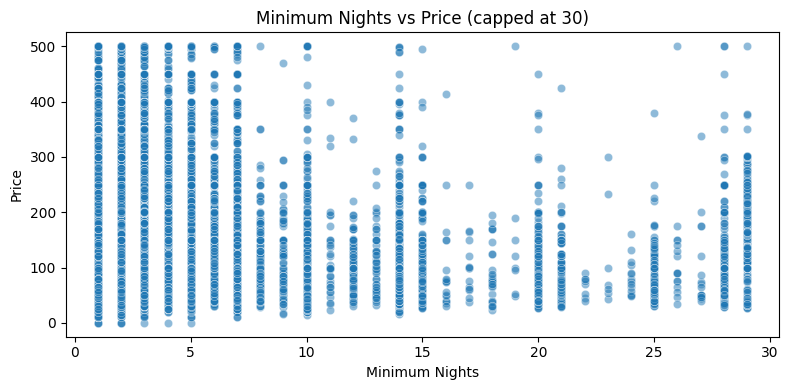

In [ ]:
# Minimum nights vs price
plt.figure(figsize=(8, 4))
sns.scatterplot(x='minimum_nights', y='price', data=df[df['minimum_nights'] < 30], alpha=0.5)
plt.title('Minimum Nights vs Price (capped at 30)')
plt.xlabel('Minimum Nights')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

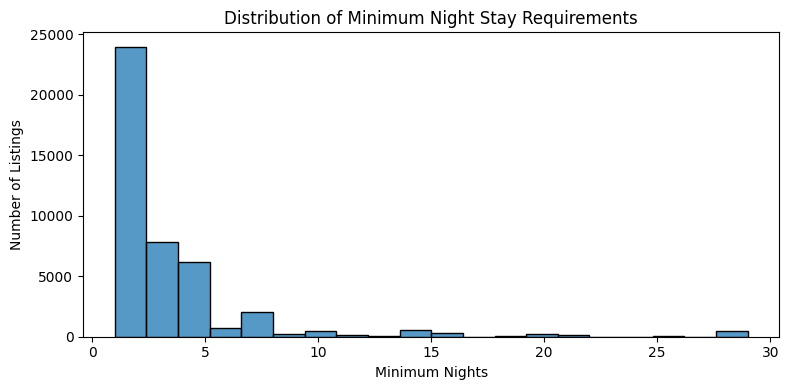

In [ ]:
# Distribution of minimum nights
plt.figure(figsize=(8, 4))
sns.histplot(df[df['minimum_nights'] < 30]['minimum_nights'], bins=20)
plt.title('Distribution of Minimum Night Stay Requirements')
plt.xlabel('Minimum Nights')
plt.ylabel('Number of Listings')
plt.tight_layout()
plt.show()

🔍 Interpretation: Most hosts opt for 1–2 nights. Listings with lower minimums may see more frequent bookings (especially in tourist-heavy areas).

<Axes: >

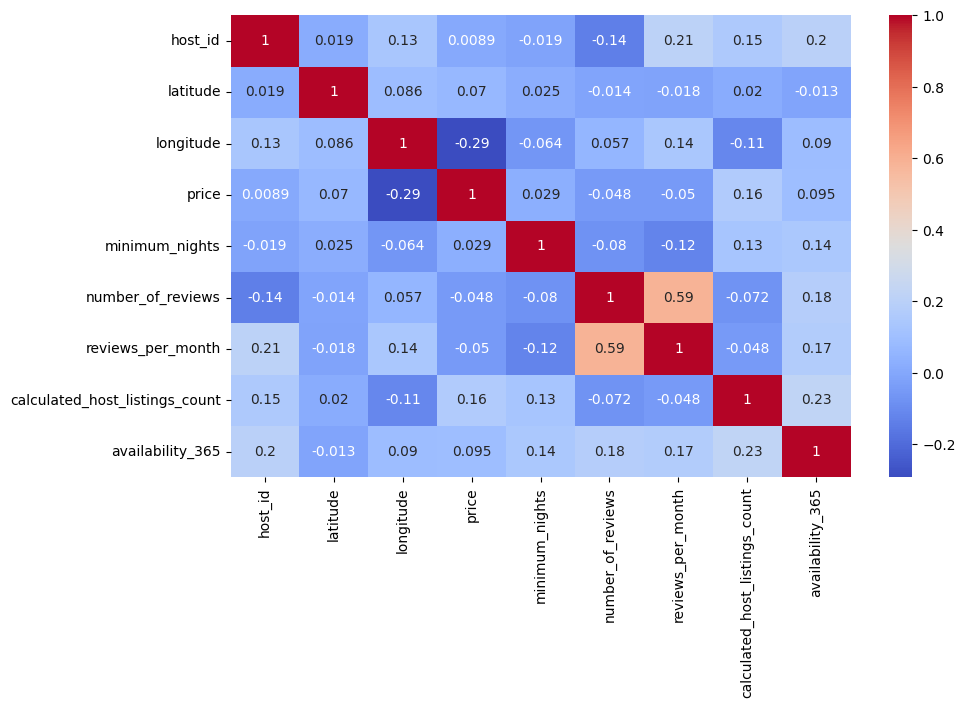

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')

###Feature Engineering

In [ ]:
# Convert categorical to numerical
df_encoded = pd.get_dummies(df, columns=['neighbourhood_group', 'room_type'], drop_first=True)

# Droping text columns
df_encoded = df_encoded.drop(['neighbourhood'], axis=1)

# Features and Target
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

###Train Models

#####using Linear Regression Algorithm

In [ ]:
# model training and selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Linear Regression:")
print("R2 Score:", r2_score(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))


Linear Regression:
R2 Score: 0.41341488497706635
RMSE: 69.28274708402593


#####using XGBoost Regressor Algorithm

In [ ]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xg_reg.fit(X_train, y_train)
y_pred_xgb = xg_reg.predict(X_test)

print("\nXGBoost Regressor:")
print("R2 Score:", r2_score(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))


XGBoost Regressor:
R2 Score: 0.5430980920791626
RMSE: 61.146422706202735


###-----XGBoost performs better-----

###Insights & Conclusion

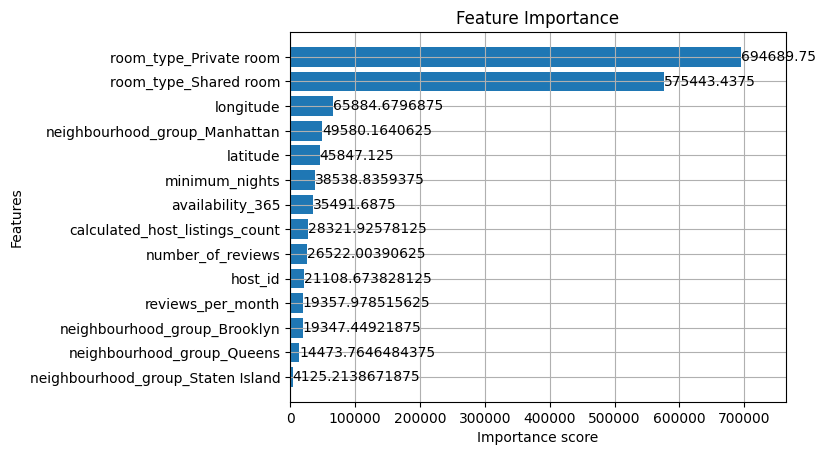

Top 5 Predictive Features:
 room_type_Private room           0.423919
room_type_Shared room            0.351151
longitude                        0.040205
neighbourhood_group_Manhattan    0.030255
latitude                         0.027977
dtype: float32


In [ ]:
# Feature Importance from XGBoost
xgb.plot_importance(xg_reg, height=0.8, importance_type='gain')
plt.title('Feature Importance')
plt.show()

# Top predictors of price
important_features = pd.Series(xg_reg.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 5 Predictive Features:\n", important_features.head())


In [29]:
def predict_price(model, input_data):
    """
    Predicts the price of an Airbnb listing using the trained model.

    Args:
        model: The trained regression model (e.g., XGBoost regressor).
        input_data (dict): A dictionary containing the input features for a single listing.
                           The keys should match the column names of the training data (X).

    Returns:
        float: The predicted price of the listing.
    """
    # Create a DataFrame from the input data
    input_df = pd.DataFrame([input_data])

    # Ensure the columns are in the same order as the training data
    input_df = input_df.reindex(columns=X.columns, fill_value=0)

    # Predict the price
    predicted_price = model.predict(input_df)

    return predicted_price[0]

# Example usage:
# Sample input data dictionary with features similar to the training data
sample_input = {
    'host_id': 12345,
    'latitude': 40.75,
    'longitude': -73.98,
    'minimum_nights': 3,
    'number_of_reviews': 50,
    'reviews_per_month': 1.5,
    'calculated_host_listings_count': 5,
    'availability_365': 100,
    'neighbourhood_group_Manhattan': 1,
    'neighbourhood_group_Queens': 0,
    'neighbourhood_group_Staten Island': 0,
    'room_type_Private room': 0,
    'room_type_Shared room': 0
}

# Predict the price using the trained XGBoost model
predicted_price_example = predict_price(xg_reg, sample_input)
print(f"The predicted price for the sample listing is: ${predicted_price_example:.2f}")

The predicted price for the sample listing is: $222.17


In [30]:
import joblib

# Saving the trained XGBoost model to a file
joblib.dump(xg_reg, 'airbnb_price_predictor_model.pkl')

print("XGBoost model saved successfully as 'airbnb_price_predictor_model.pkl'")

XGBoost model saved successfully as 'airbnb_price_predictor_model.pkl'
